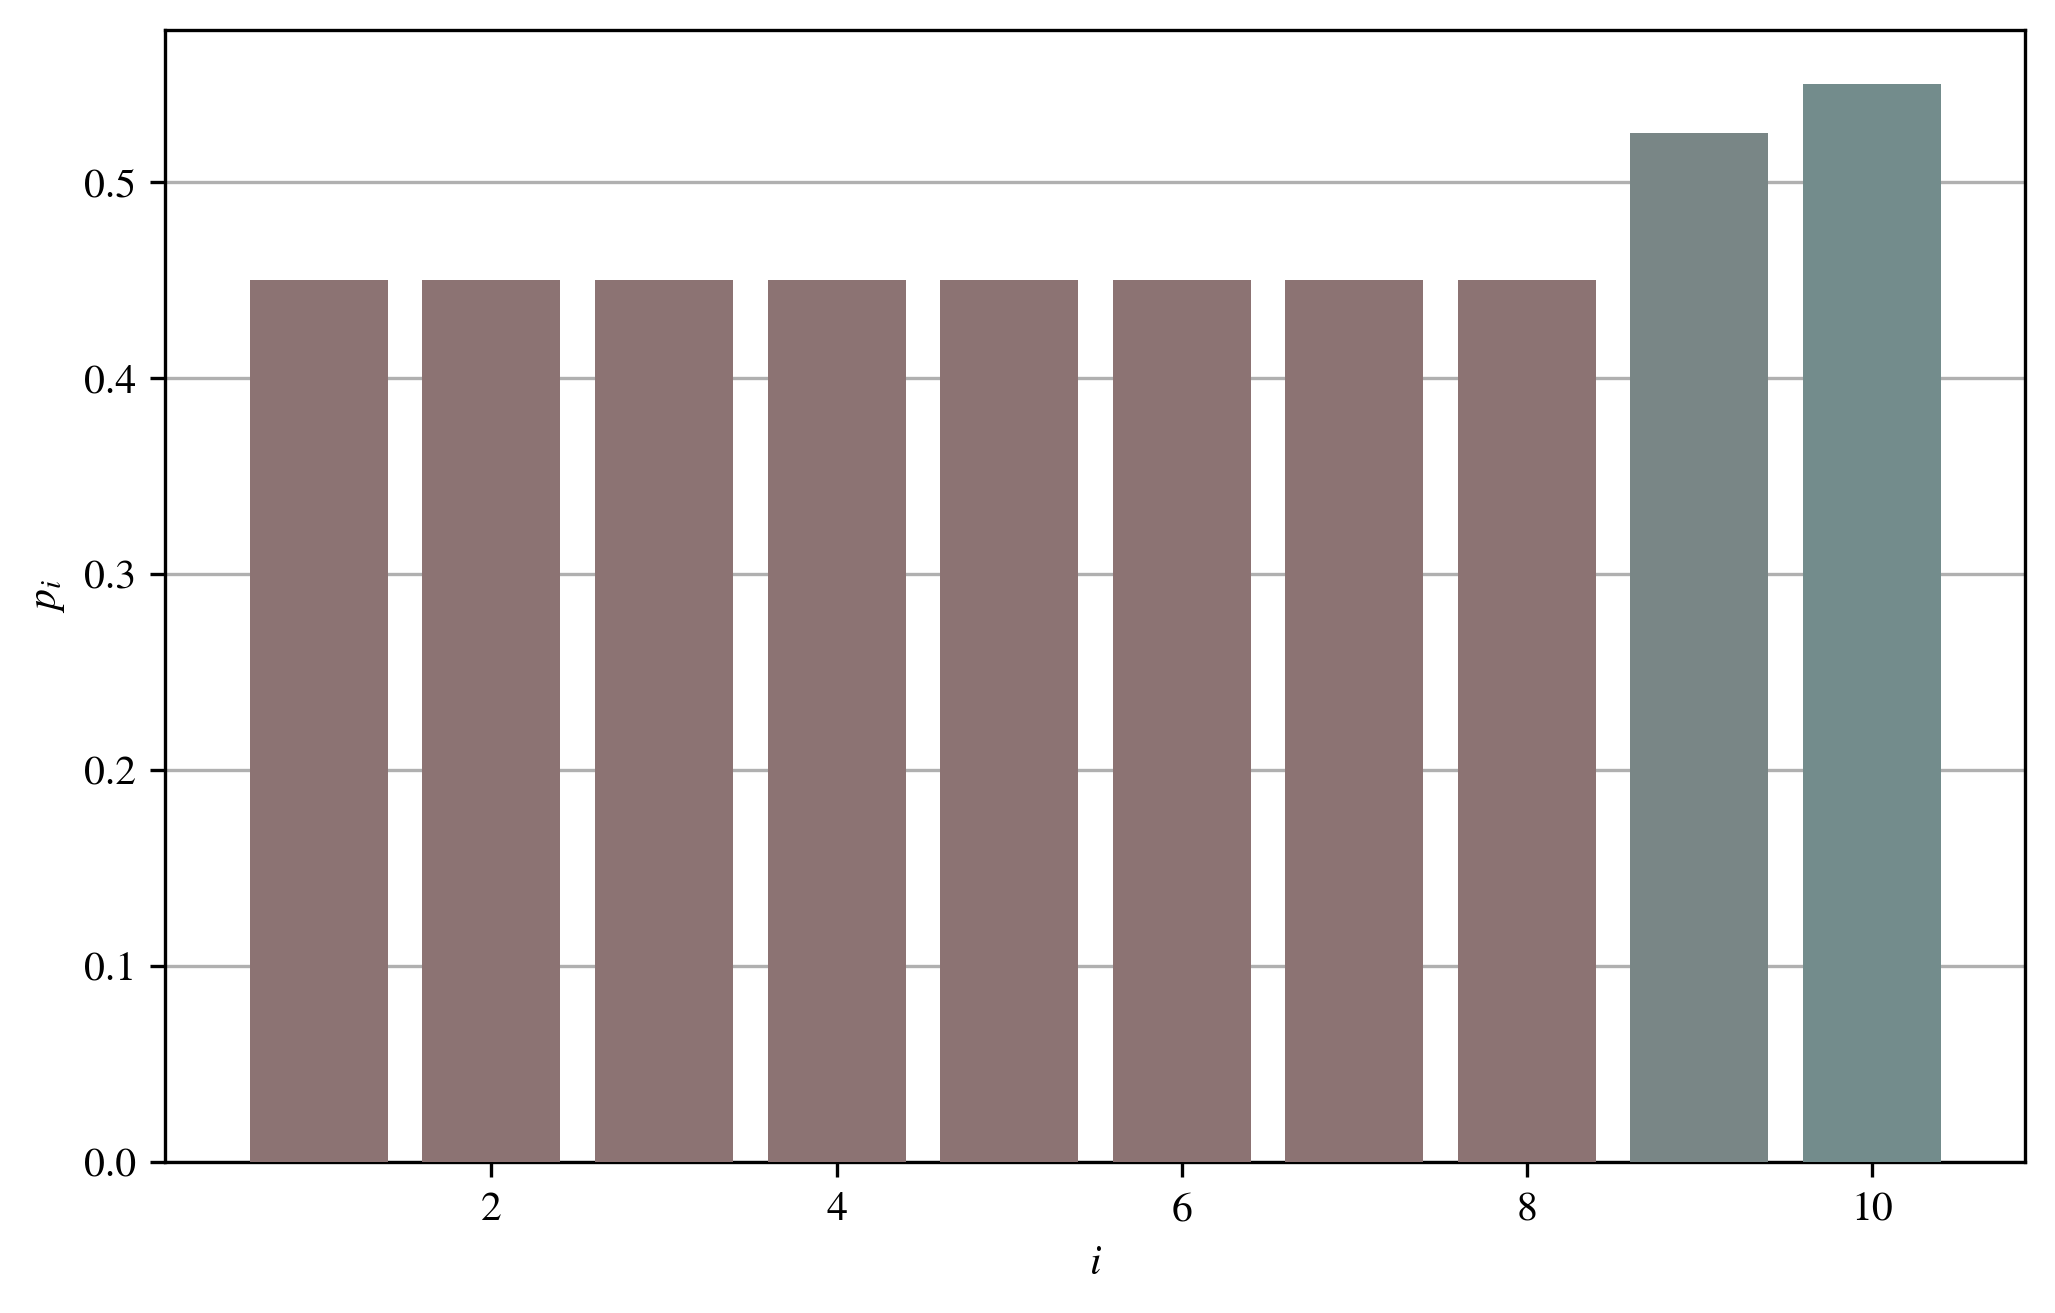

  0%|          | 0/120 [00:00<?, ?it/s]

../../packages/magb\magb\simulator.py:309: RuntimeWarning: divide by zero encountered in true_divide
  self.fr_a = sr_a / self.SR[:,:,-1,np.newaxis]
../../packages/magb\magb\simulator.py:309: RuntimeWarning: invalid value encountered in true_divide
  self.fr_a = sr_a / self.SR[:,:,-1,np.newaxis]
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [19]:
#Import Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from scipy.stats import norm

from datetime import datetime
import pickle

#current date
date = datetime.now().strftime("%Y_%m_%d")

#save pickle
save_pickle = False

#matplolib with latex style
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300

mpl.rcParams["figure.figsize"] = (8,5)

#Configure path for local packages
import setup

from magb.arms import RandomArm, BernoulliArm, GaussianArm, TruncGaussianArm
from magb.policies import FixedPolicy, GreedyPolicy, RandomPolicy, EpsilonGreedyPolicy, EmpiricalSumPolicy
from magb.policies import ExploreThenExploitPolicy, SequentialExploreThenExploitPolicy, SequentialPolicy
from magb.policies import SoftMaxPolicy, UCBPolicy, ThompsonPolicy, GamblerThompsonPolicy, BayesUCBPolicy, GamblerBayesUCBPolicy
from magb.policies import PositiveGreedyPolicy, GamblerUCBPolicy
from magb.simulator import SMAB

#number of arms and corresponding parameters
#k = 10
#p_arr = np.linspace(0.0, 0.6, k)
#p_arr = [0.325, 0.350, 0.375, 0.400, 0.425, 0.450, 0.475, 0.500, 0.525, 0.550]
p_arr = [0.45] * 8 + [0.525, 0.55]
k = len(p_arr)

#Bernoulli
arms = [BernoulliArm(p, minr=-1.0, maxr=+1.0) for p in p_arr]

#initial budget
b_0 = k
omega = k 

#each arm must be tried at least w times at beginning
w=1

fig, ax = plt.subplots(1)
ax.grid(visible=True, which='major', axis='y', zorder=0)
ax.set_xlabel('$i$')
ax.set_ylabel('$p_i$')
for i, p in enumerate(p_arr):
    ax.bar(i+1, p, zorder=3, color=(1-p, p, p, 1.0))
plt.show()

#algorithms
algs = [
     #FixedPolicy(k, w=w, fixed_i=k, label="Best Arm"),
     #FixedPolicy(k, w=w, fixed_i=1, label="Worst Arm"),
     GreedyPolicy(k, w=w),
     EpsilonGreedyPolicy(k, w=w, eps=0.01, label="Eps 0.01", style={'color':'g', 'linestyle':':'}), 
     #EpsilonGreedyPolicy(k, w=w, eps=0.05, label="Eps 0.05", style={'color':'r', 'linestyle':':'}), 
     EpsilonGreedyPolicy(k, w=w, eps=0.1, label="Eps 0.1", style={'color':'b', 'linestyle':':'}), 
     #UCBPolicy(k, w=w, r_min=-1.0, r_max=1.0, alpha_prime=0.01, label="UCB 0.01"),
     #UCBPolicy(k, w=w, r_min=-1.0, r_max=1.0, alpha_prime=0.05, label="UCB 0.05"),
     UCBPolicy(k, w=w, r_min=-1.0, r_max=1.0, alpha_prime=0.1, label="UCB 0.1", style={'color':'r', 'linestyle':'-.'}),
     UCBPolicy(k, w=w, r_min=-1.0, r_max=1.0, alpha_prime=0.5, label="UCB 0.5", style={'color':'g', 'linestyle':'-.'}),
     #UCBPolicy(k, w=w, r_min=-1.0, r_max=1.0, alpha_prime=1.0, label="UCB 1.0", style={'color':'k', 'linestyle':'-.'}),
     UCBPolicy(k, w=w, r_min=-1.0, r_max=1.0, alpha_prime=2.0, label="UCB 2.0", style={'color':'b', 'linestyle':'-.'}),
     #GamblerUCBPolicy(k, w=w, b_0=b_0, r_min=-1.0, r_max=1.0, alpha_prime=0.01, label="Gambler UCB 0.01"),
     #GamblerUCBPolicy(k, w=w, b_0=b_0, r_min=-1.0, r_max=1.0, alpha_prime=0.05, label="Gambler UCB 0.05"),
     GamblerUCBPolicy(k, w=w, b_0=b_0, r_min=-1.0, r_max=1.0, alpha_prime=0.1, label="Gambler-UCB 0.1", style={'color':'r', 'linestyle':'-'}),
     GamblerUCBPolicy(k, w=w, b_0=b_0, r_min=-1.0, r_max=1.0, alpha_prime=0.5, label="Gambler-UCB 0.5", style={'color':'g', 'linestyle':'-'}),
     #GamblerUCBPolicy(k, w=w, b_0=b_0, r_min=-1.0, r_max=1.0, alpha_prime=1.0, label="Gambler-UCB 1.0", style={'color':'k', 'linestyle':'-'}),
     GamblerUCBPolicy(k, w=w, b_0=b_0, r_min=-1.0, r_max=1.0, alpha_prime=2.0, label="Gambler-UCB 2.0", style={'color':'b', 'linestyle':'-'}),
     #PositiveGreedyPolicy(k, w=w, label="Positive Greedy"),
     ThompsonPolicy(k, w=w, style={'color':'c', 'linestyle':'--'}),
     #GamblerThompsonPolicy(k, w=w, b_0=b_0),
     BayesUCBPolicy(k, w=w, label="Bayes-UCB", style={'color':'m', 'linestyle':'--'}),
     GamblerBayesUCBPolicy(k, w=w, b_0=b_0, label="Gambler-Bayes-UCB", style={'color':'m', 'linestyle':'-'}) 
    ]

colors = ['r', 'tan', 'm', 'g', 'orange', 'c',  'b', 'k',  'y', 'darkgrey', 'darkblue', 'darkgreen']
smooth_window = 100

#time-horizon
h = 1000

#repetitions
n = 120

sim5 = SMAB(arms, algs, h, b_0, n=n, use_multiprocess=True)
sim5.run(tqdm_leave=True)

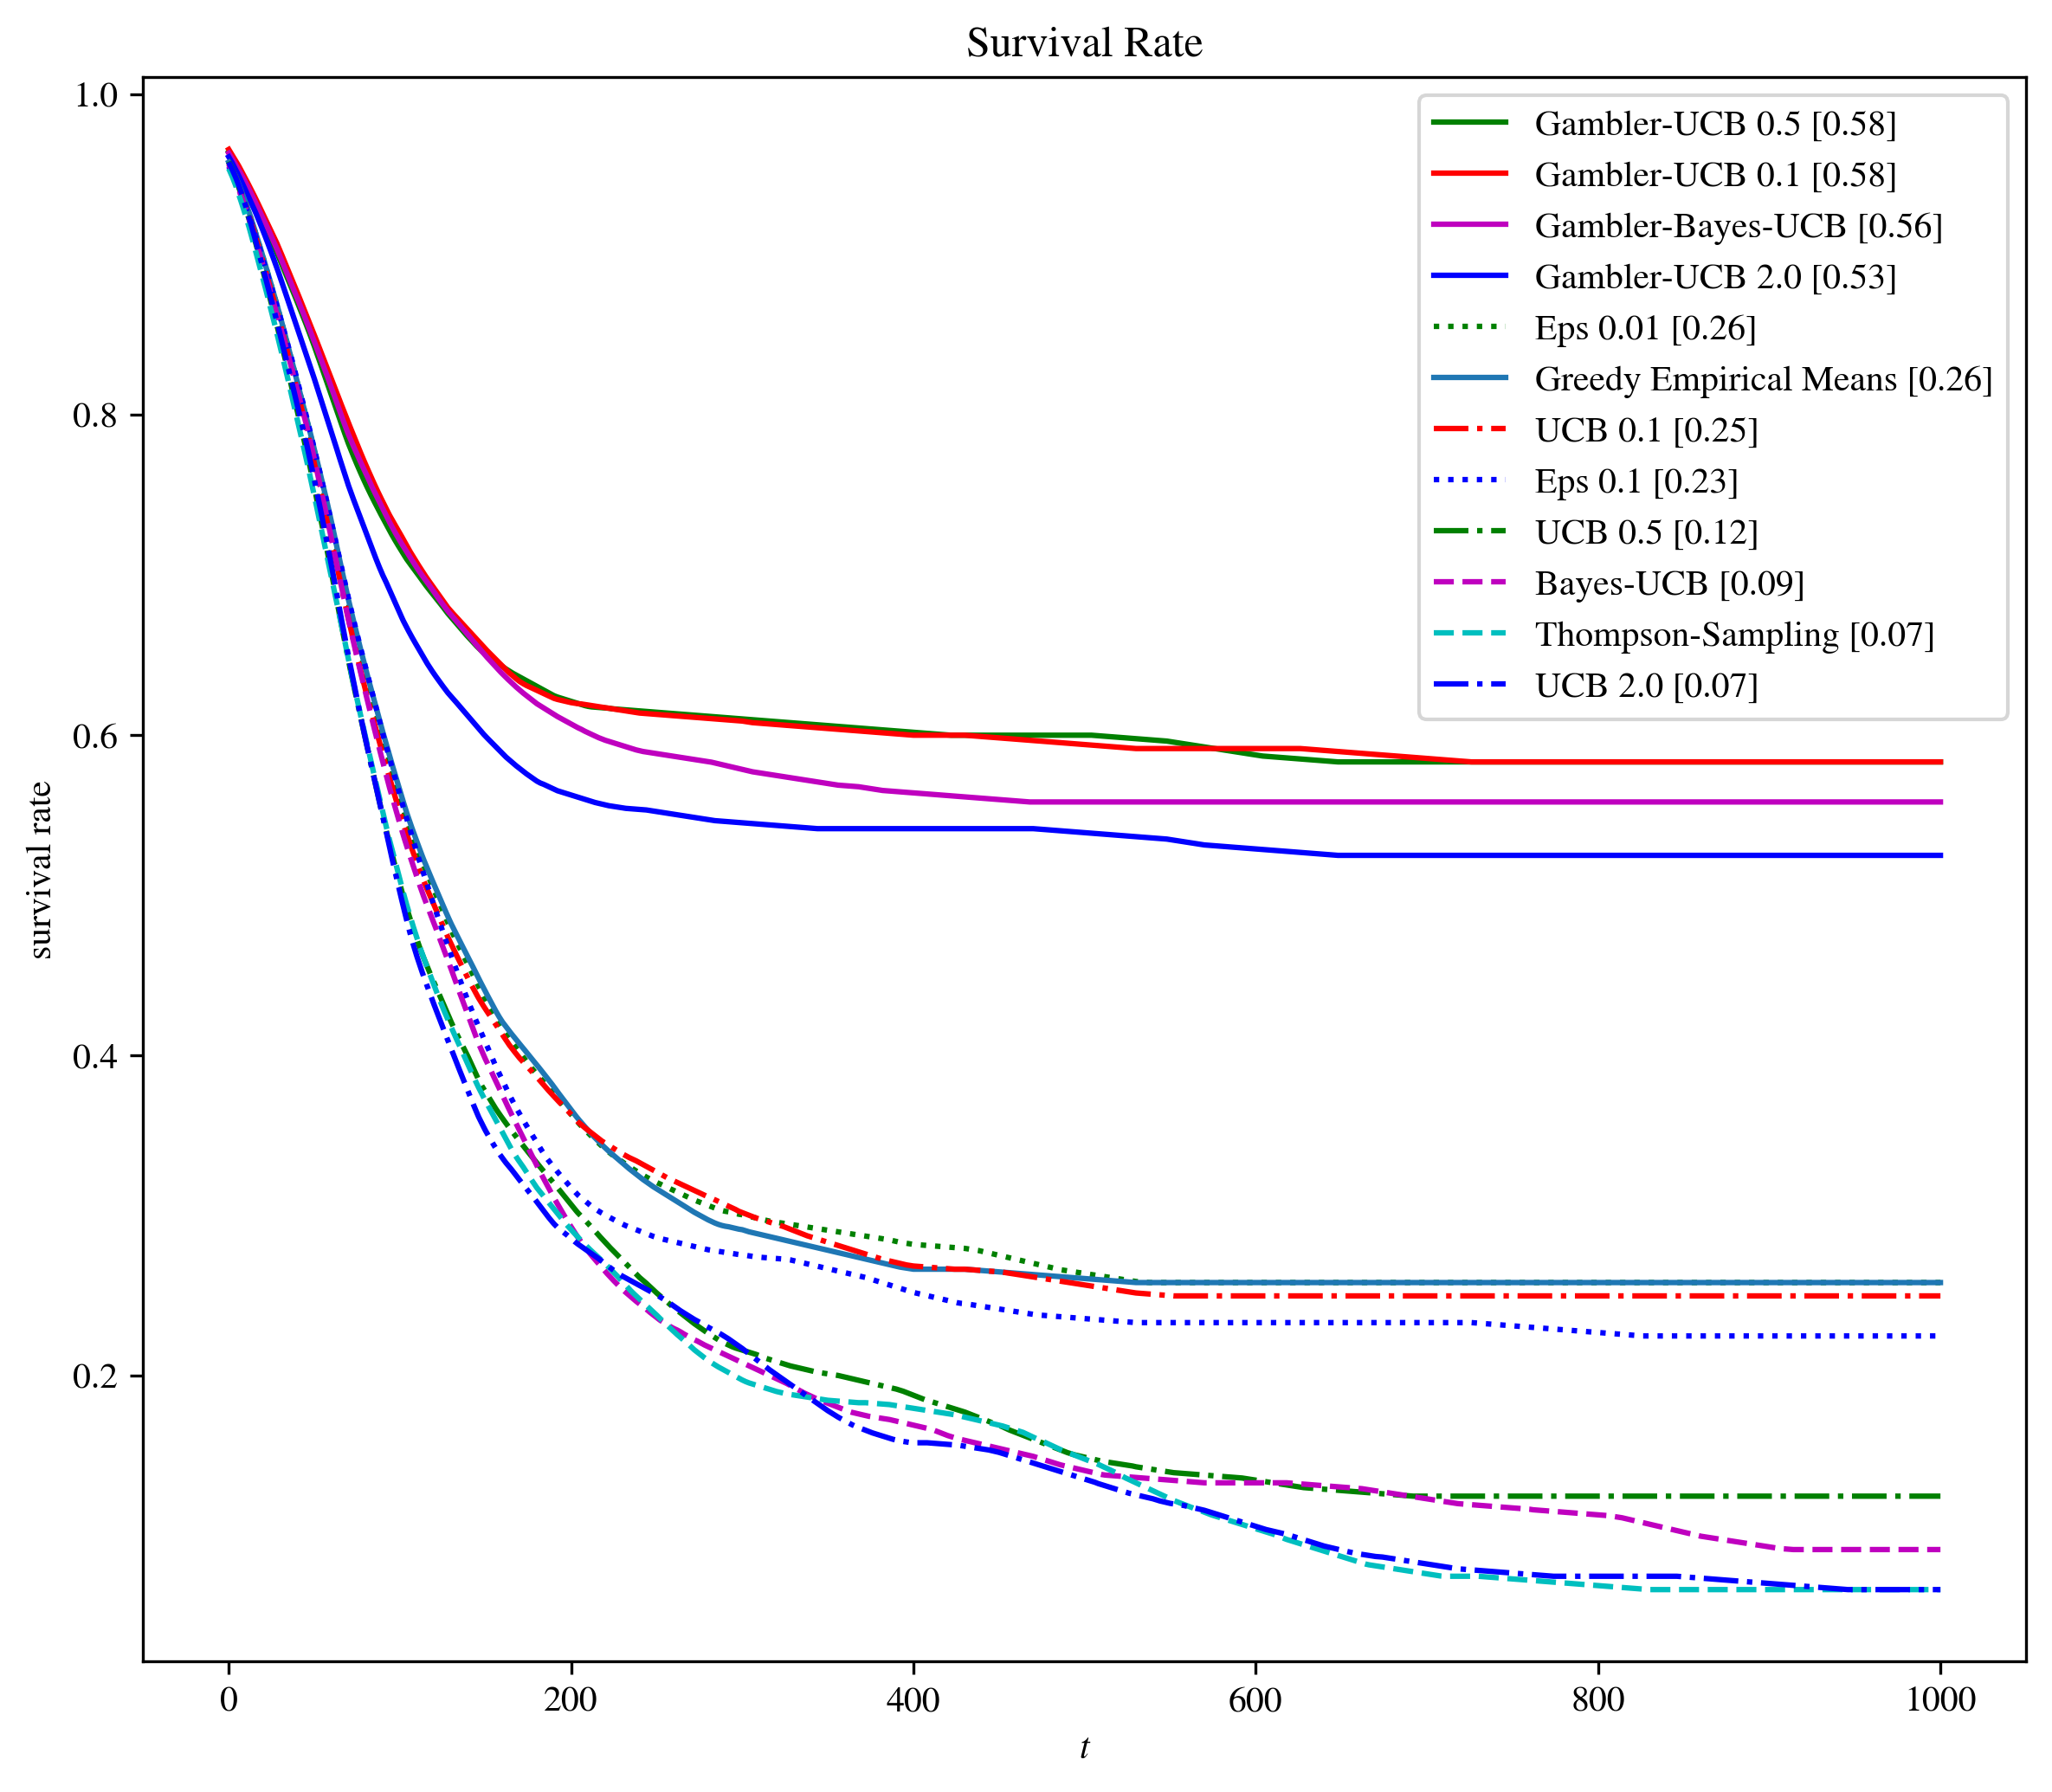

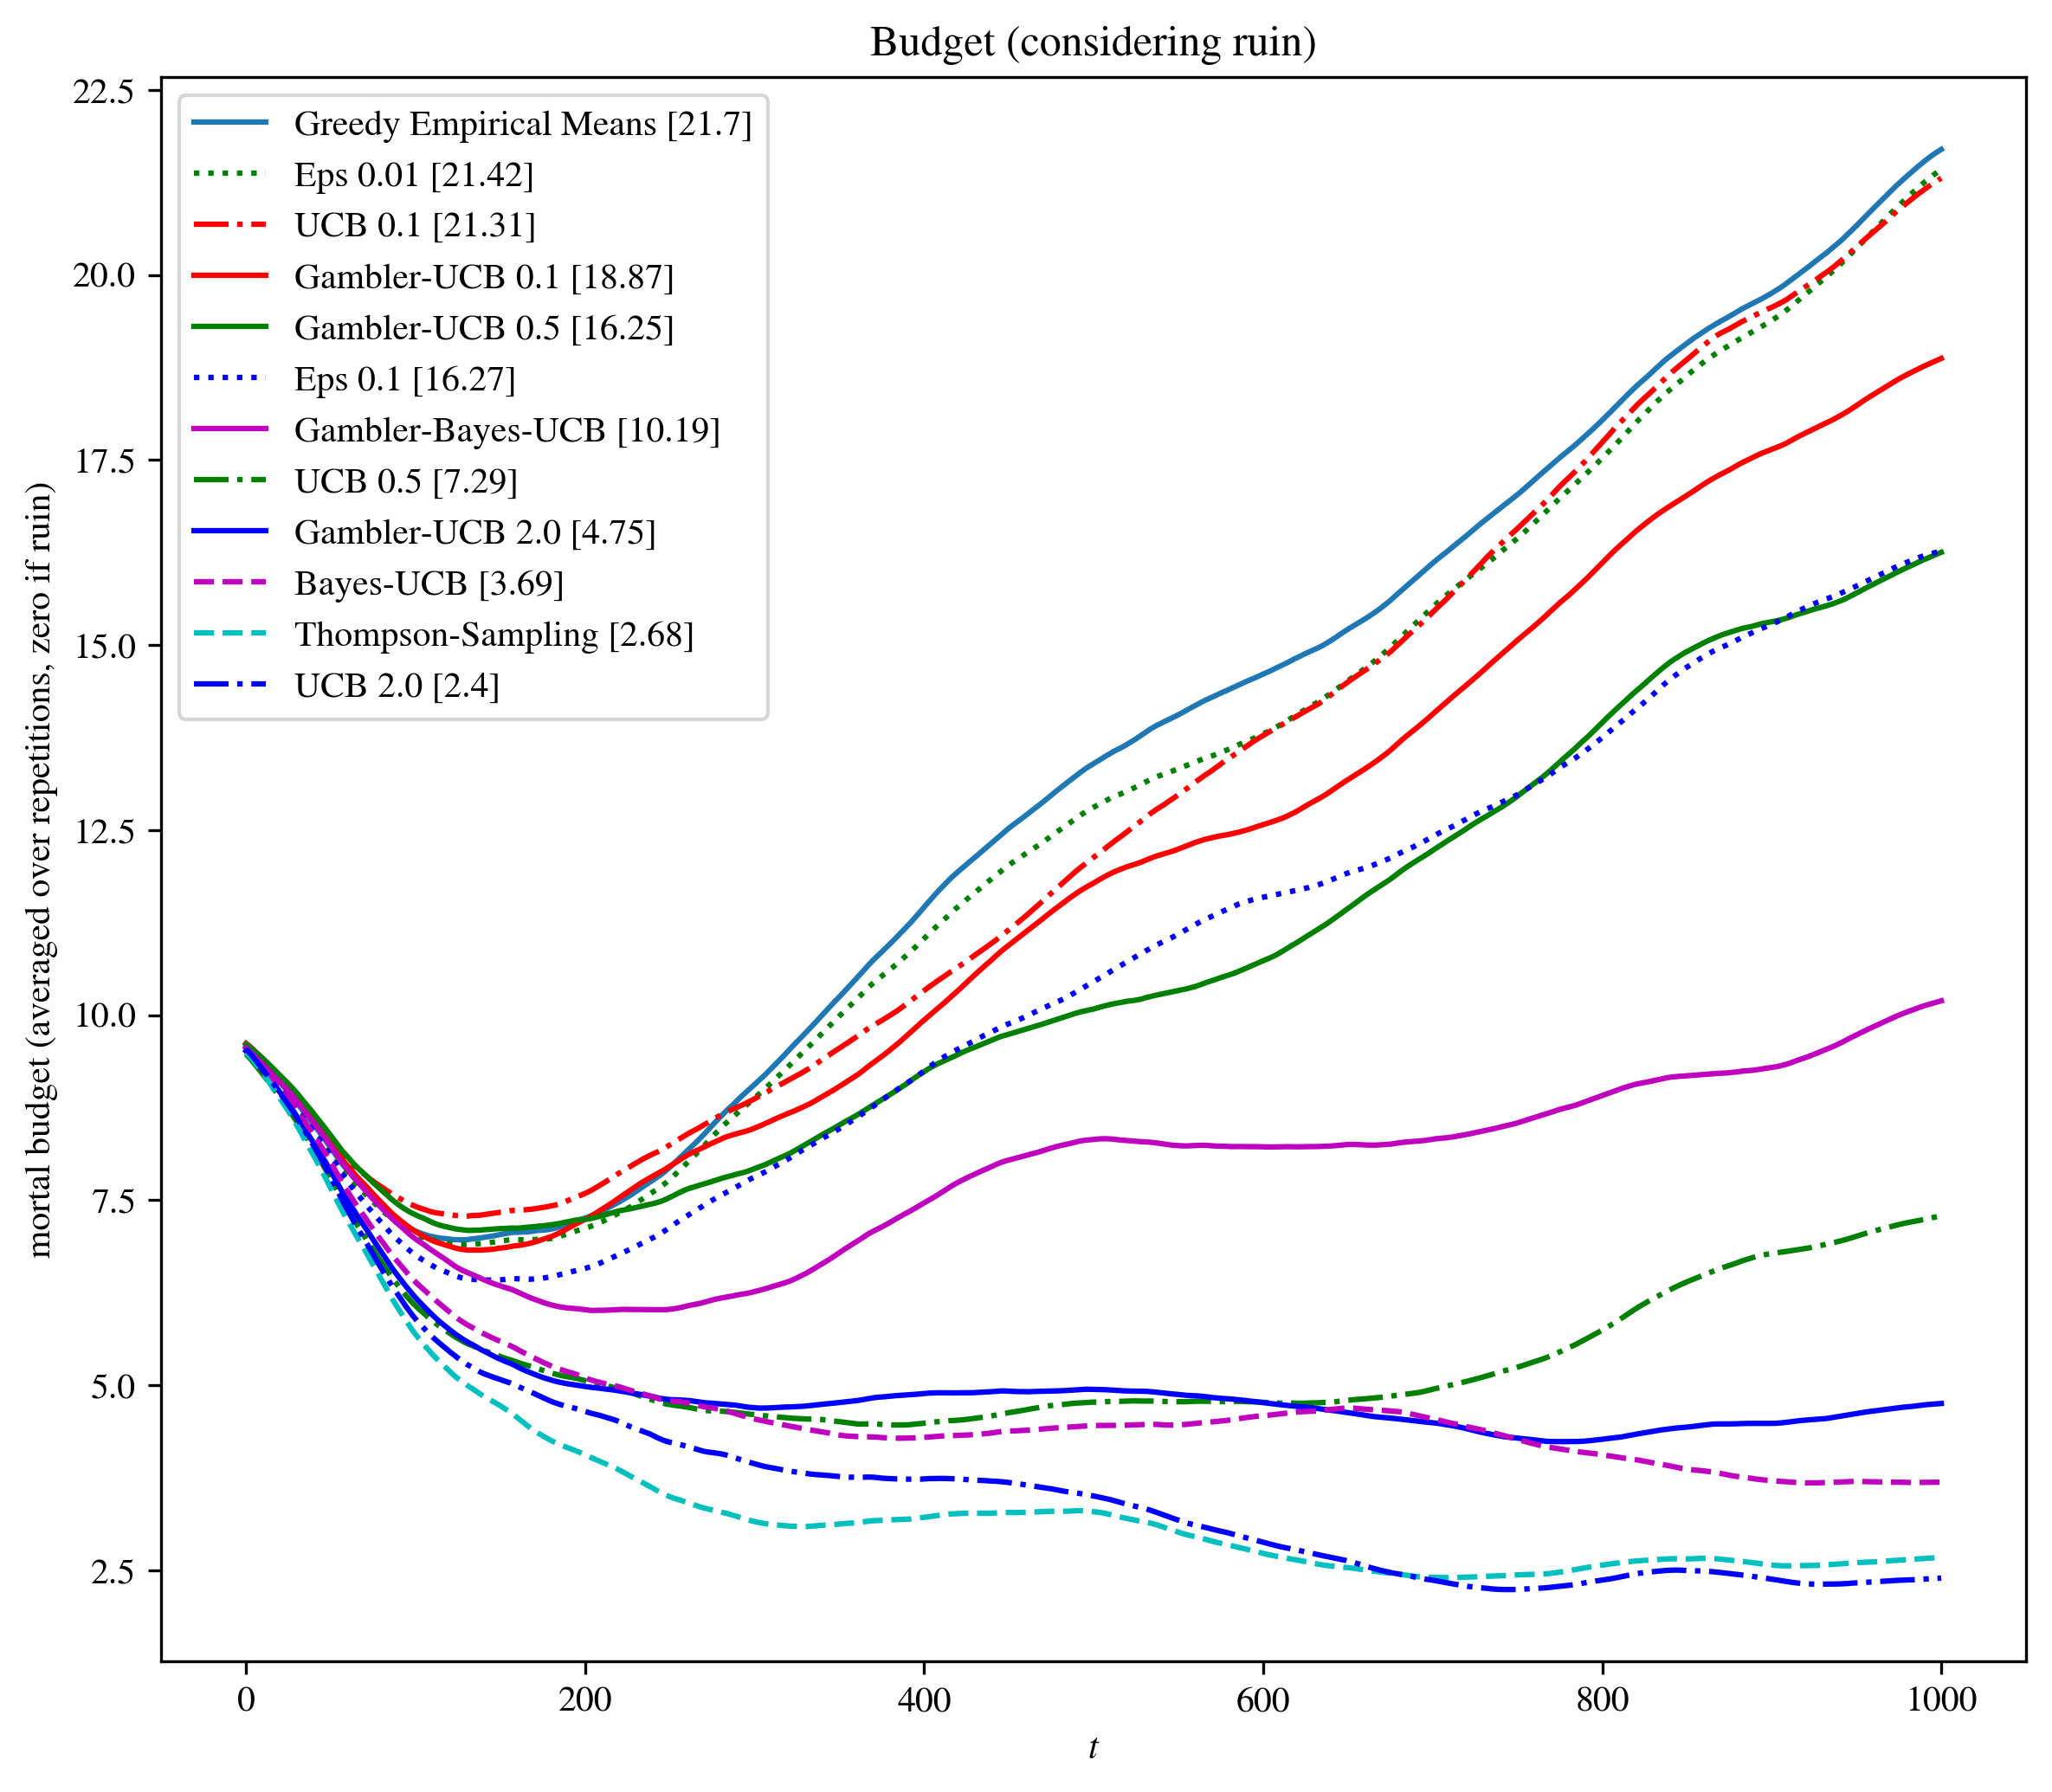

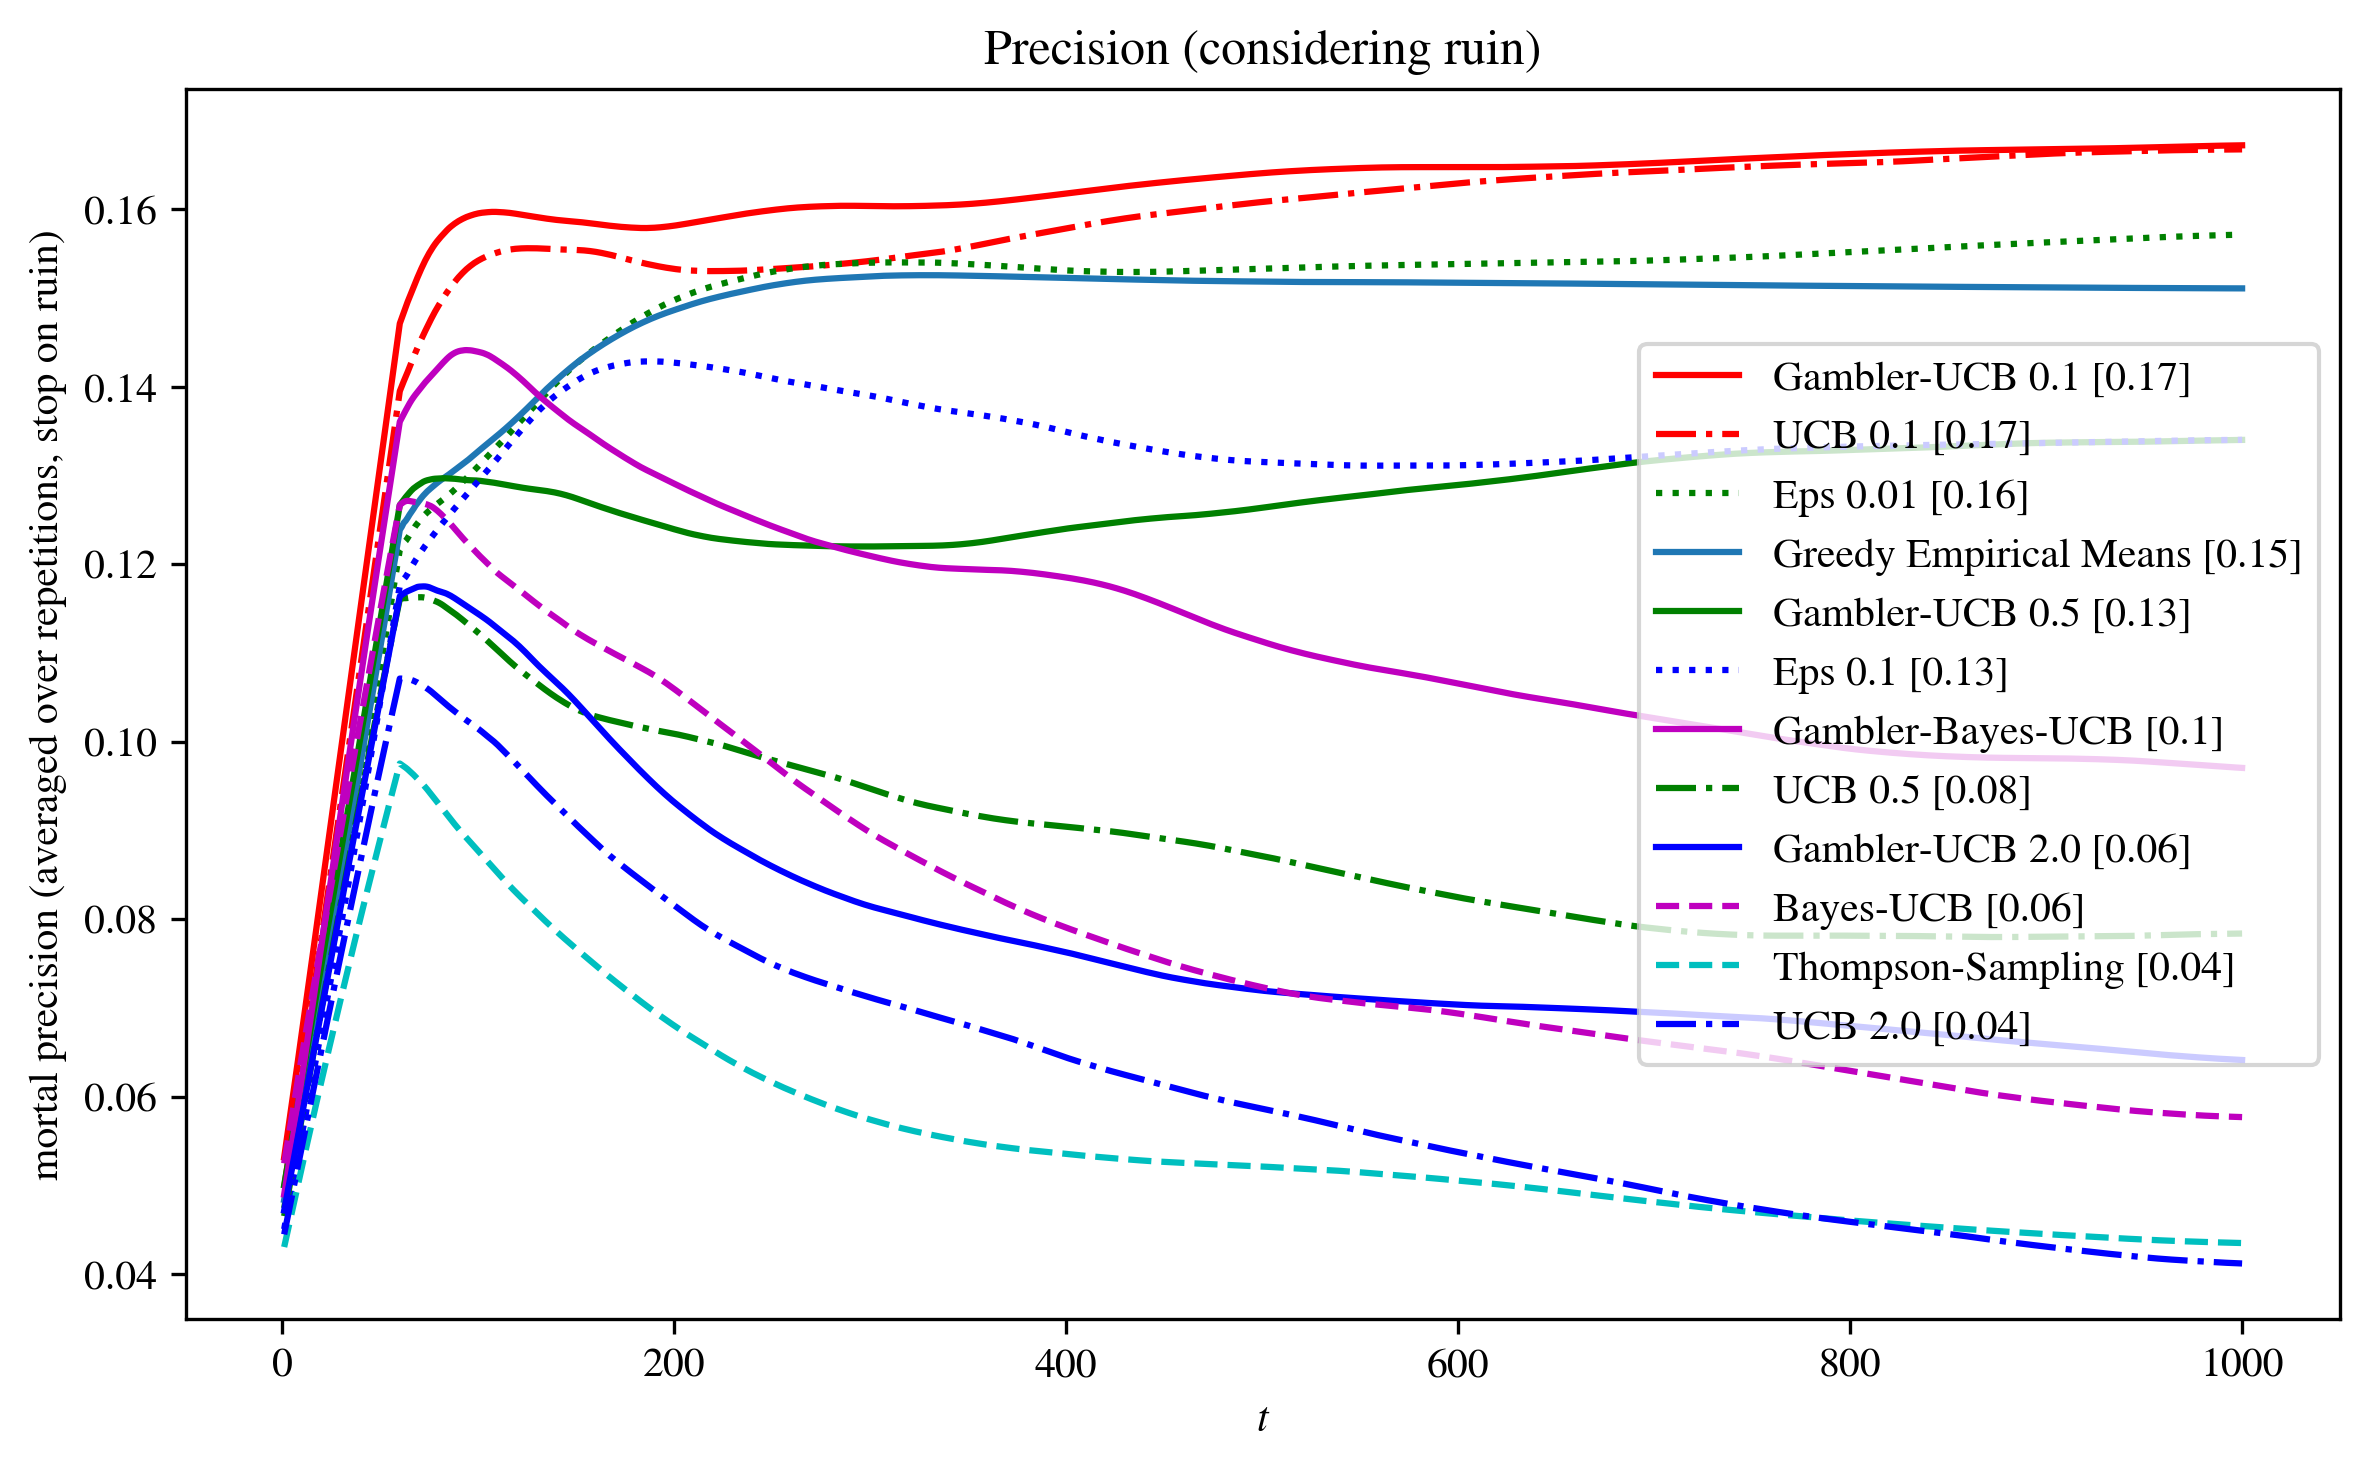

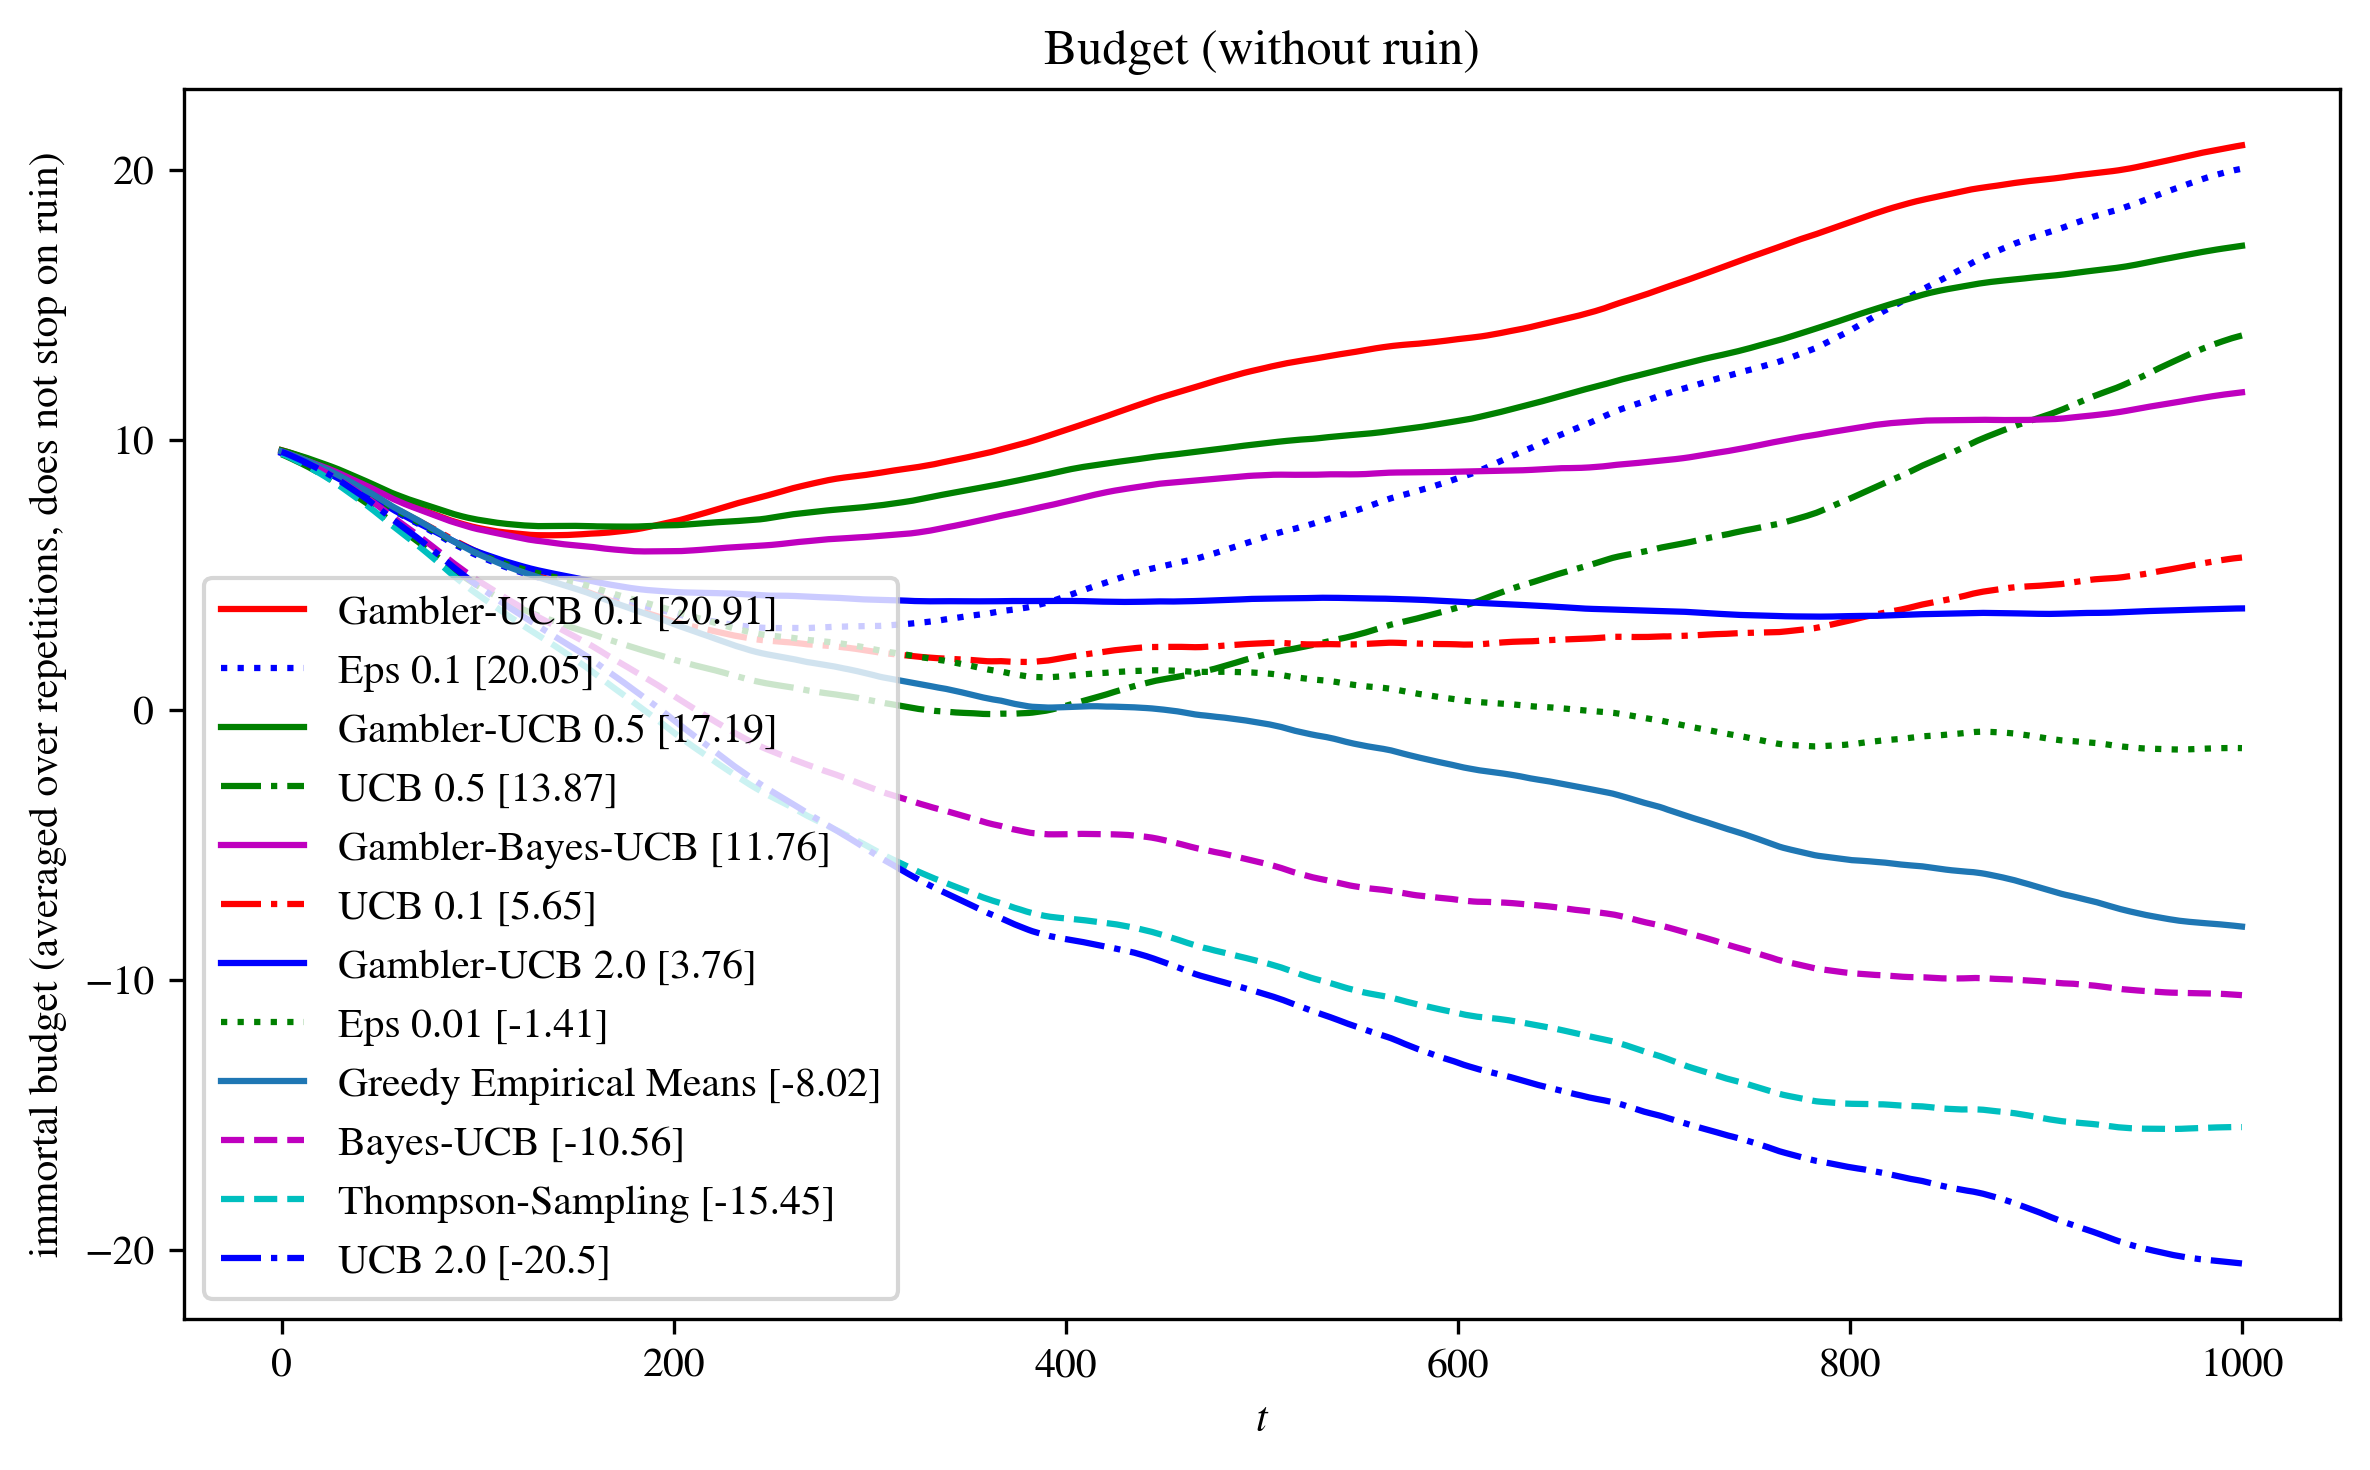

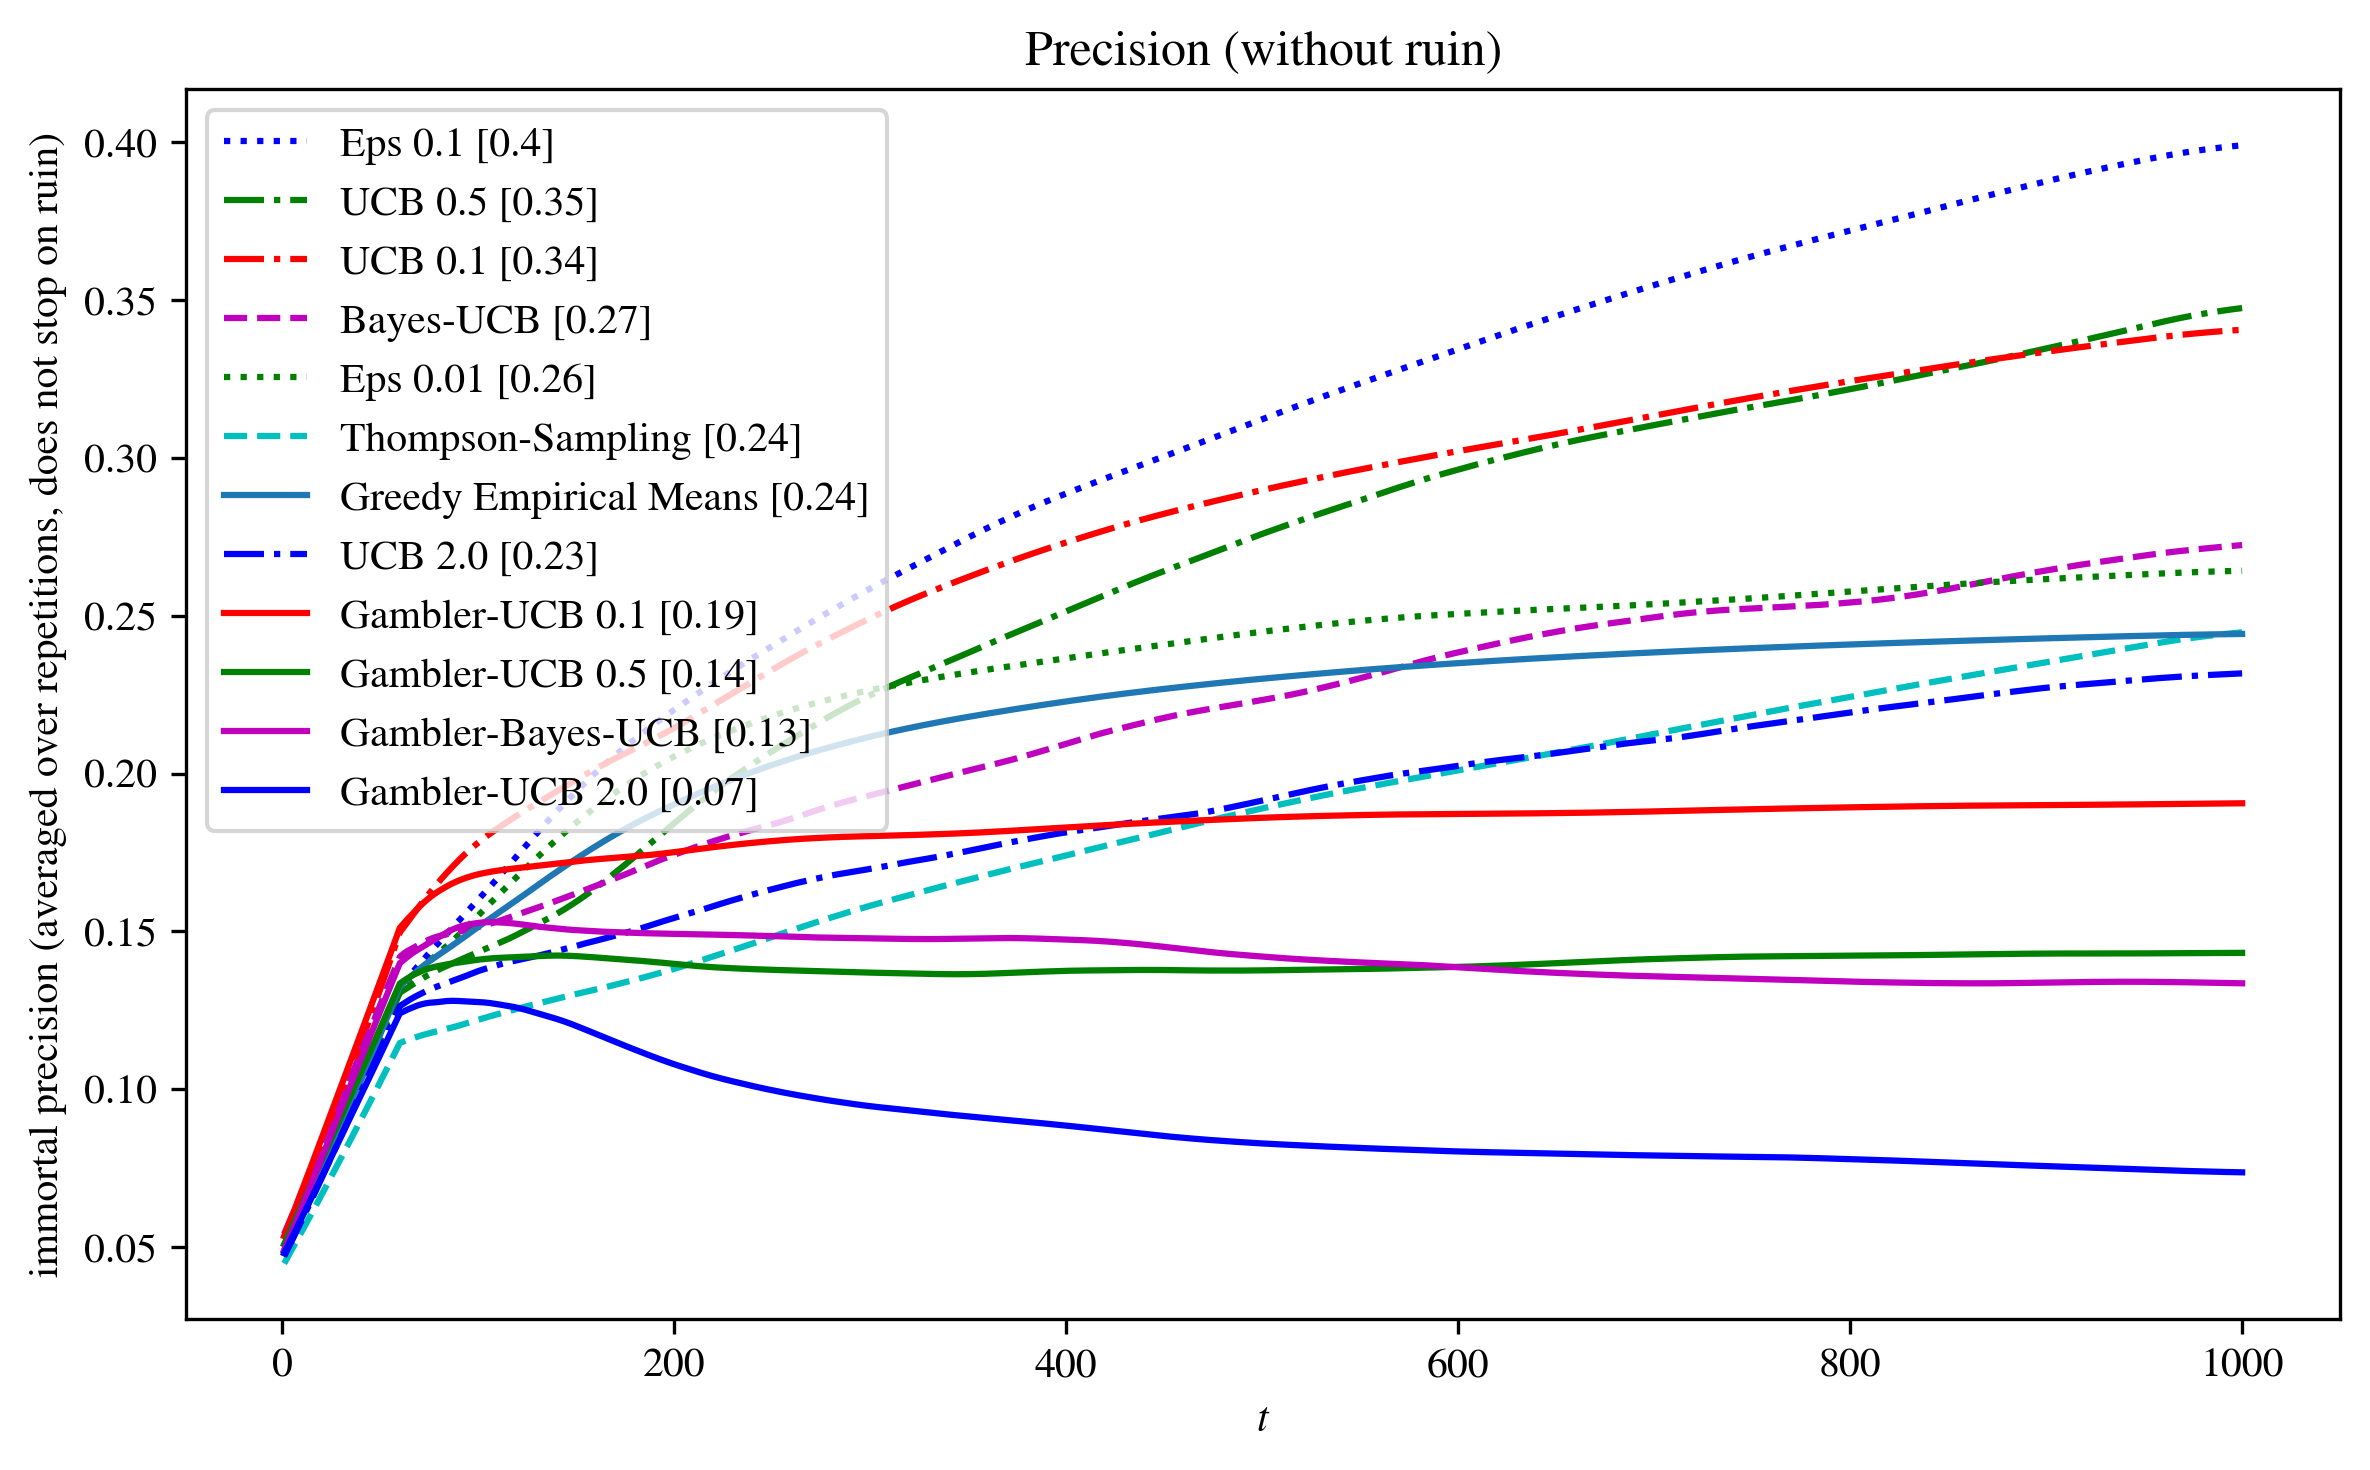

In [20]:
colors = ['k', 'b', 'g', 'k', 'b', 'g',  'k', 'b',  'g', 'r', 'k', 'r']
styles = [':', ':', ':', '-.', '-.', '-.',  '-', '-',  '-', '--', '--', '-']

sim5.plot('survival', filename='survival.pdf', smooth_window=smooth_window, figsize=(8,7))
sim5.plot('mortal_budget', filename='mortal_budget.pdf', smooth_window=smooth_window, figsize=(8,7))
sim5.plot('mortal_precision', filename='mortal_precision.pdf', smooth_window=smooth_window)
sim5.plot('immortal_budget', filename='immortal_budget.pdf', smooth_window=smooth_window)
sim5.plot('immortal_precision', filename='immortal_precision.pdf', smooth_window=smooth_window)
#sim5.plot('avg_reward', filename='avg.pdf', linecolors=colors, smooth_window=smooth_window)
#sim5.plot('avg_mortal_reward', filename='avg2.pdf', linecolors=colors, smooth_window=smooth_window)


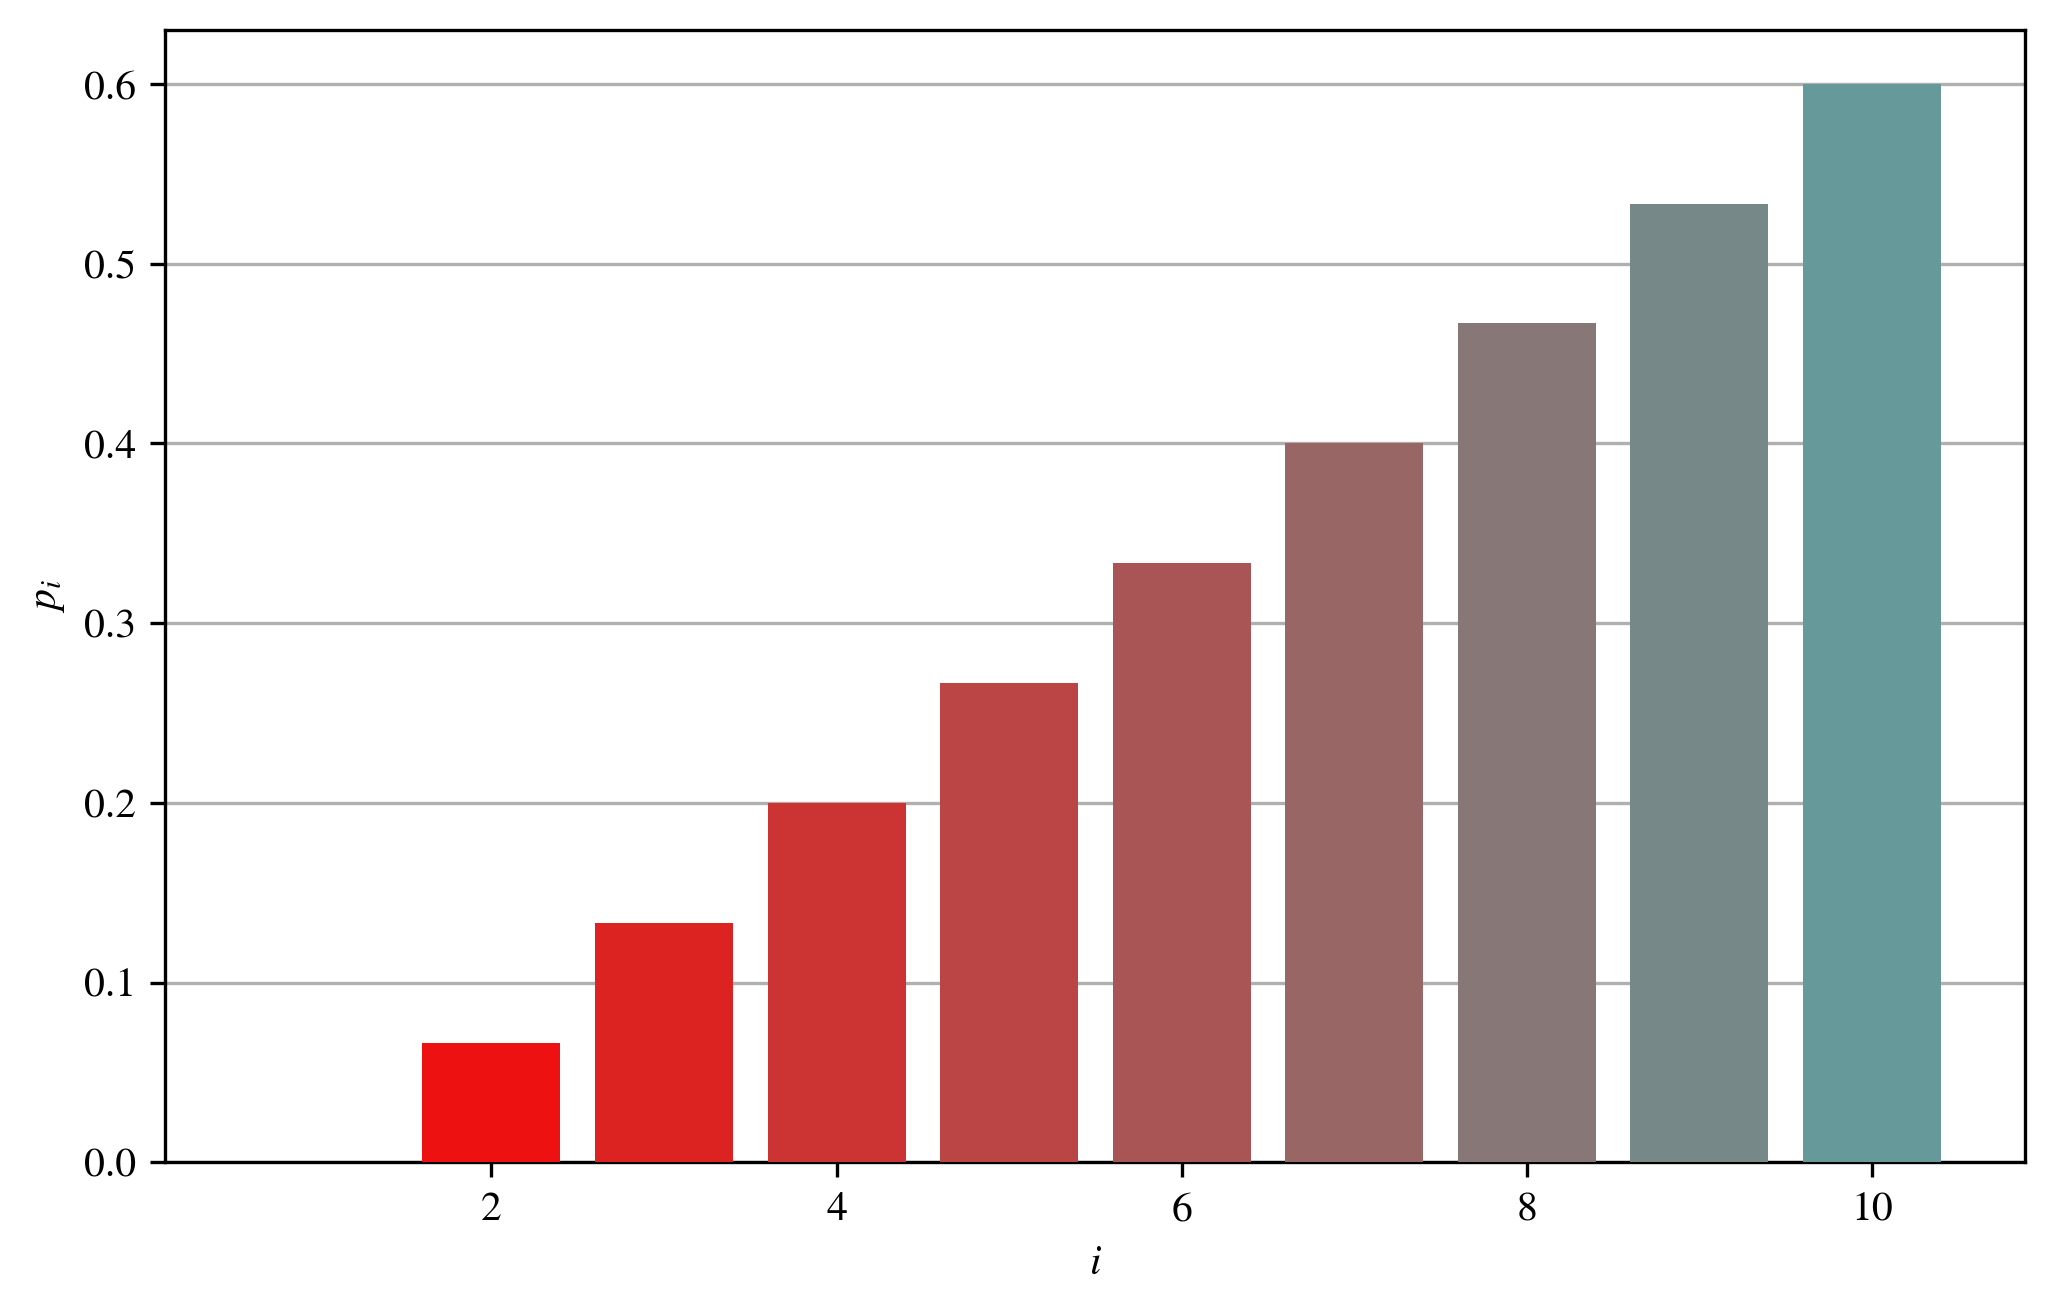

  0%|          | 0/5 [00:00<?, ?it/s]

../../packages/magb\magb\simulator.py:309: RuntimeWarning: divide by zero encountered in true_divide
  self.fr_a = sr_a / self.SR[:,:,-1,np.newaxis]
../../packages/magb\magb\simulator.py:309: RuntimeWarning: invalid value encountered in true_divide
  self.fr_a = sr_a / self.SR[:,:,-1,np.newaxis]


TypeError: plot() got an unexpected keyword argument 'linecolors'

In [3]:
k = 10
p_arr = np.linspace(0.0, 0.6, k)

#Bernoulli
arms = [BernoulliArm(p, minr=-1.0, maxr=+1.0) for p in p_arr]

fig, ax = plt.subplots(1)
ax.grid(visible=True, which='major', axis='y', zorder=0)
ax.set_xlabel('$i$')
ax.set_ylabel('$p_i$')
for i, p in enumerate(p_arr):
    ax.bar(i+1, p, zorder=3, color=(1-p, p, p, 1.0))
plt.show()

sim6 = SMAB(arms, algs, h, b_0, n=n, use_multiprocess=False)
sim6.run(tqdm_leave=True)

sim6.plot('mortal_budget', smooth_window=smooth_window)
sim6.plot('survival', smooth_window=smooth_window)
sim6.plot('immortal_budget', smooth_window=smooth_window)
sim6.plot('precision', smooth_window=smooth_window)